In [96]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, TargetEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.tree import *
from xgboost import *
from sklearn.svm import *
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import (
    KNeighborsClassifier,
    RadiusNeighborsClassifier
)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
traindata = pd.read_csv("/kaggle/input/titanic/train.csv")
testdata = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
df = pd.concat([traindata, testdata])

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [6]:
result = df.duplicated().sum()
result

np.int64(0)

In [7]:
drop_cols = ['Name', 'PassengerId', 'Cabin', 'Ticket']
df = df.drop(columns=drop_cols)

Text(0.5, 1.0, 'Percentage Distribution per Category')

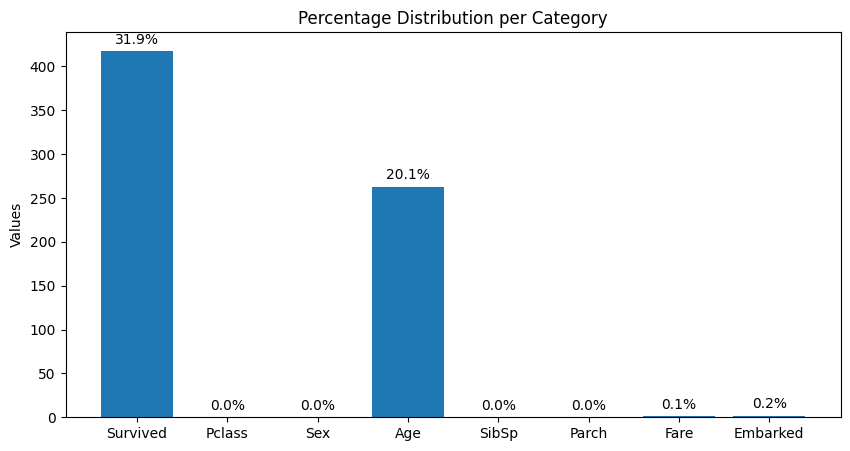

In [8]:
result = df.isnull().sum()
total = df.shape[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bars = ax.bar(result.index, result.values)
labels = [f'{(v/total)*100:.1f}%' for v in result.values]
ax.bar_label(bars, labels=labels, padding=3)
ax.set_ylabel('Values')
ax.set_title('Percentage Distribution per Category')

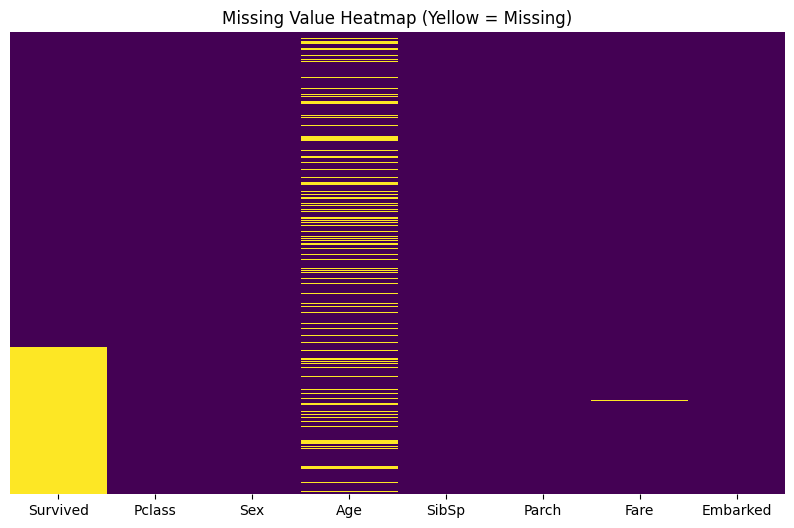

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title("Missing Value Heatmap (Yellow = Missing)")
plt.show()

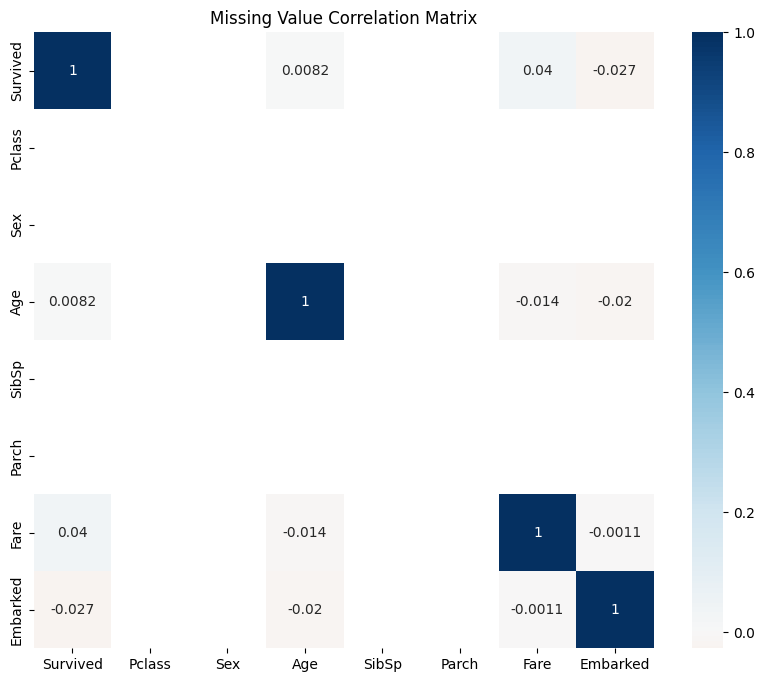

In [10]:
missing_corr = df.isnull().corr()
plt.figure(figsize=(10, 8))
sns.heatmap(missing_corr, annot=True, cmap='RdBu', center=0)
plt.title("Missing Value Correlation Matrix")
plt.show()

In [11]:
missingness_target_corr = df.isnull().corrwith(df['Survived'])

print(missingness_target_corr.sort_values(ascending=False))

Embarked    0.060095
Age        -0.092197
Survived         NaN
Pclass           NaN
Sex              NaN
SibSp            NaN
Parch            NaN
Fare             NaN
dtype: float64


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [12]:
num_cols = ['Age', 'Fare', 'SibSp', 'Parch']
cat_cols = [col for col in df.columns if col not in num_cols]

In [13]:
def analyze_numerical(df, col):
    print(f"--- Analysis for: {col} ---")

    desc = df[col].describe()
    skew = df[col].skew()
    kurt = df[col].kurtosis()
    
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    
    print(f"Mean: {desc['mean']:.2f} | Median: {desc['50%']:.2f}")
    print(f"Skewness: {skew:.2f} | Kurtosis: {kurt:.2f}")
    print(f"Outliers detected: {outliers_count} (Bounds: {lower_bound:.2f} to {upper_bound:.2f})\n")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    sns.histplot(df[col], kde=True, ax=axes[0], color='royalblue')
    axes[0].set_title('Histogram & KDE')
    
    sns.violinplot(x=df[col], ax=axes[1], color='lightgray', inner=None)
    sns.boxplot(x=df[col], ax=axes[1], width=0.3, color='skyblue', showmeans=True)
    axes[1].set_title('Box & Violin Plot')
    
    stats.probplot(df[col], dist="norm", plot=axes[2])
    axes[2].set_title('Probability (Q-Q) Plot')
    
    plt.tight_layout()
    plt.show()

In [14]:
df = df.reset_index(drop=True)

--- Analysis for: Age ---
Mean: 29.88 | Median: 28.00
Skewness: 0.41 | Kurtosis: 0.15
Outliers detected: 9 (Bounds: -6.00 to 66.00)



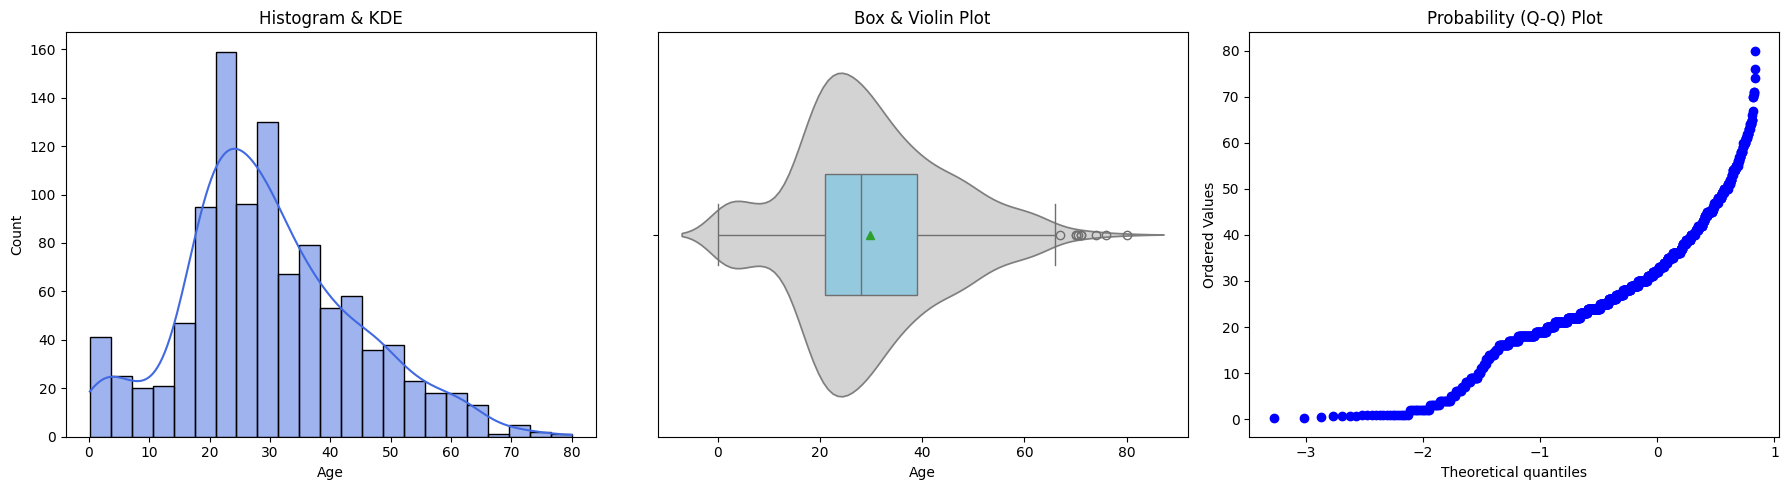

--- Analysis for: Fare ---
Mean: 33.30 | Median: 14.45
Skewness: 4.37 | Kurtosis: 27.03
Outliers detected: 171 (Bounds: -27.17 to 66.34)



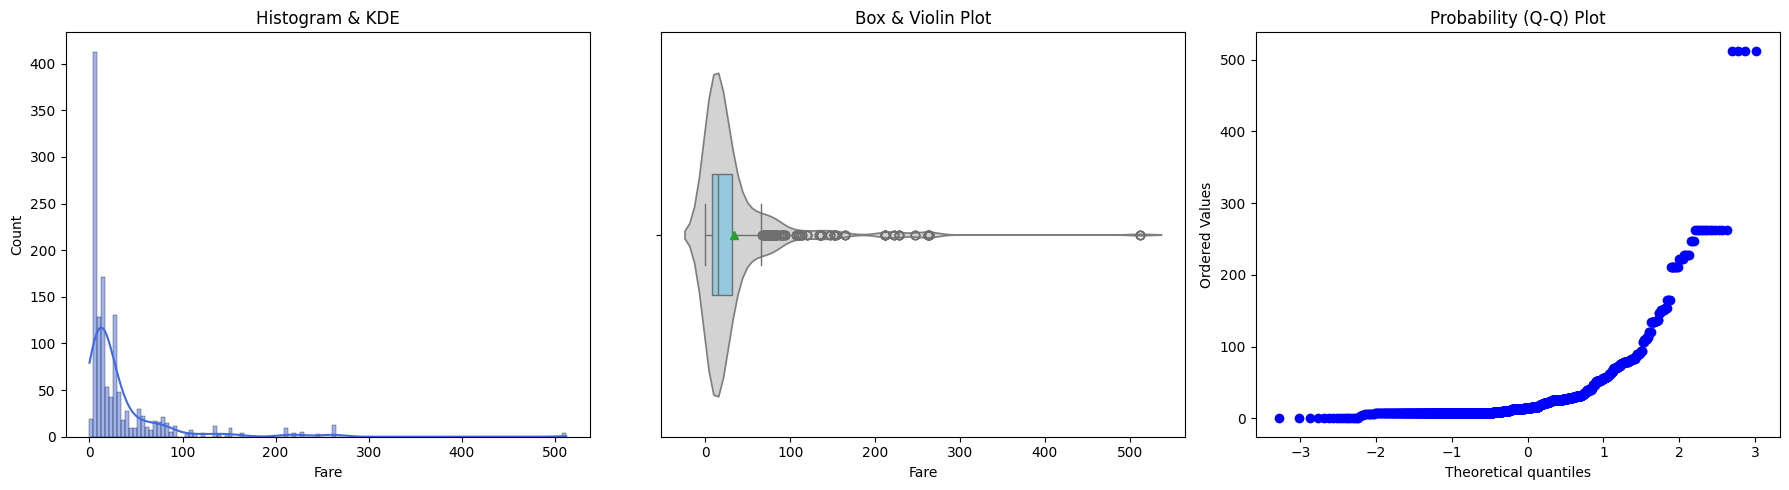

--- Analysis for: SibSp ---
Mean: 0.50 | Median: 0.00
Skewness: 3.84 | Kurtosis: 20.04
Outliers detected: 57 (Bounds: -1.50 to 2.50)



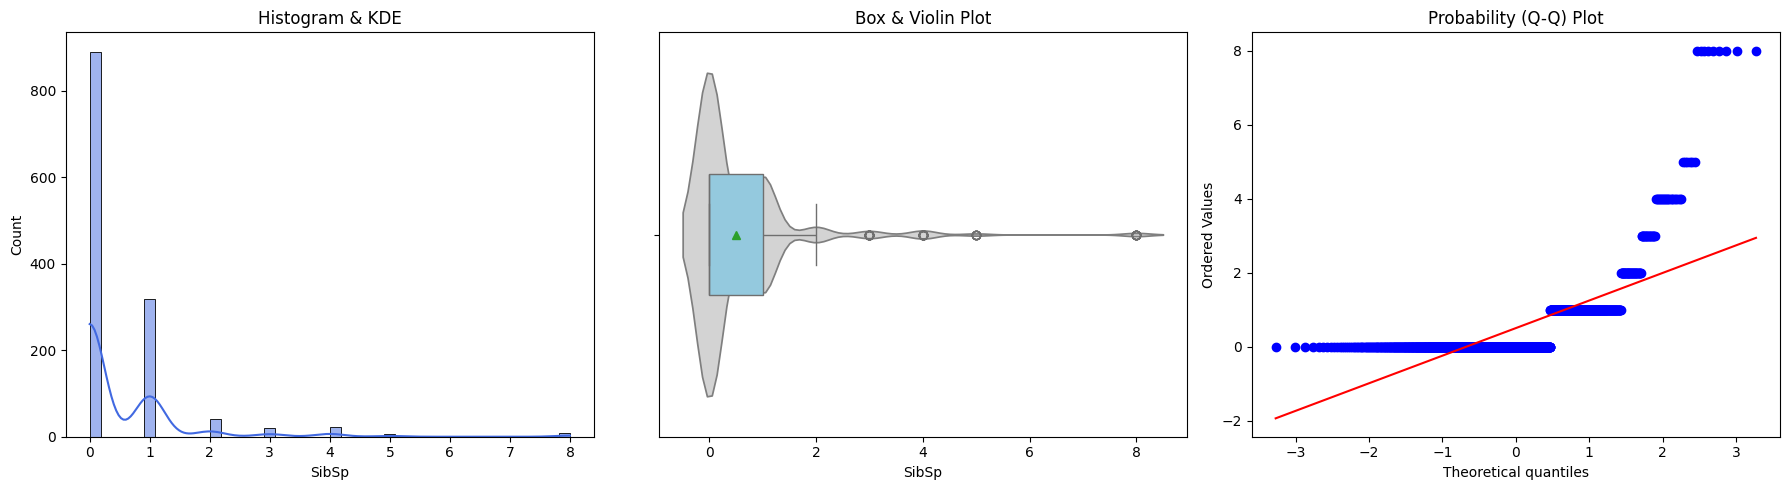

--- Analysis for: Parch ---
Mean: 0.39 | Median: 0.00
Skewness: 3.67 | Kurtosis: 21.54
Outliers detected: 307 (Bounds: 0.00 to 0.00)



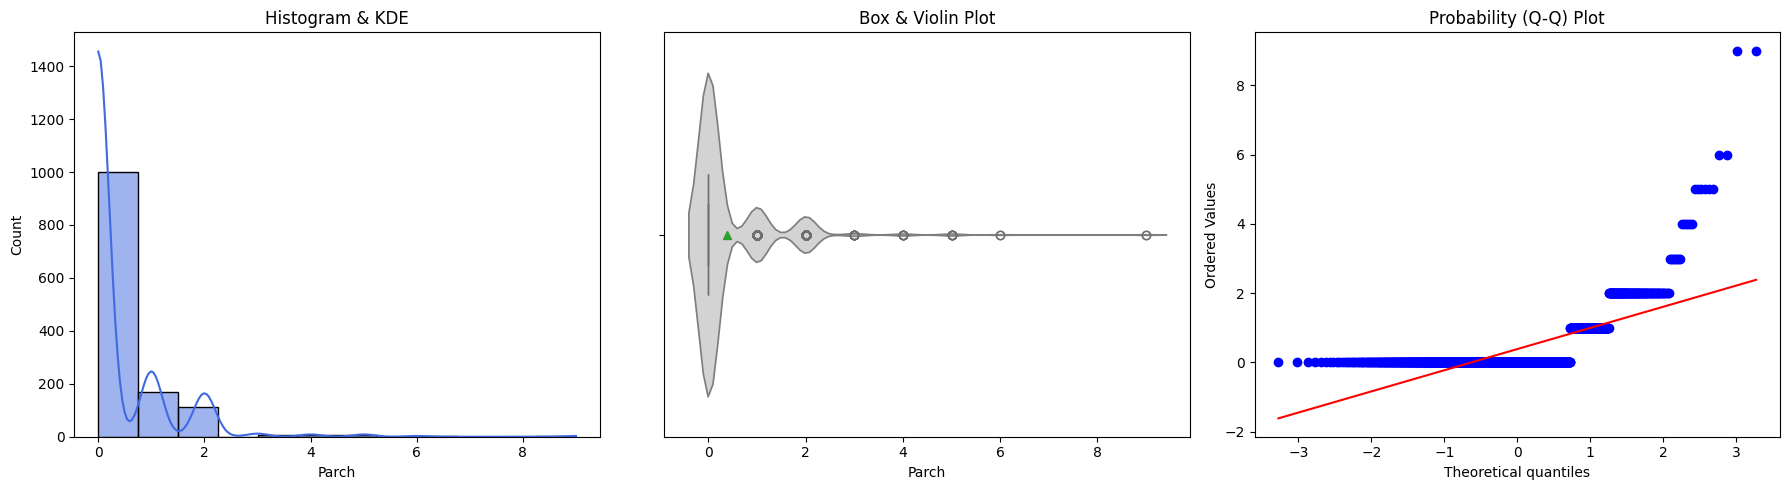

In [15]:
for col in num_cols:
    analyze_numerical(df, col)

In [16]:
def analyze_categorical(df, col, rare_threshold=5):
    print(f"--- Categorical Analysis: {col} ---")
    
    series = df[col].astype("category")
    
    counts = series.value_counts()
    percent = series.value_counts(normalize=True) * 100

    
    summary = pd.DataFrame({
        "Count": counts,
        "Percentage": percent
    })
    
    cardinality = series.nunique()
    dominant_cat = percent.idxmax()
    dominant_pct = percent.max()
    
    print(f"Cardinality (unique): {cardinality}")
    print(f"Dominant category: {dominant_cat} ({dominant_pct:.1f}%)")
    
    rare_cats = percent[percent < rare_threshold].index.tolist()
    if rare_cats:
        print(f"Rare categories (<{rare_threshold}%): {rare_cats}")
    else:
        print("No rare categories")
    
    plt.figure(figsize=(10, 4))
    
    ax = sns.barplot(
        x=summary.index,
        y=summary["Count"],
        hue=summary.index,
        palette="viridis",
        legend=False,
        order=summary.index,
    )
    
    for i, (cnt, pct) in enumerate(zip(counts, percent)):
        ax.text(i, cnt, f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)
    
    plt.title(f"Frequency Distribution: {col}")
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    print("-" * 40 + "\n")

--- Categorical Analysis: Survived ---
Cardinality (unique): 2
Dominant category: 0.0 (61.6%)
No rare categories


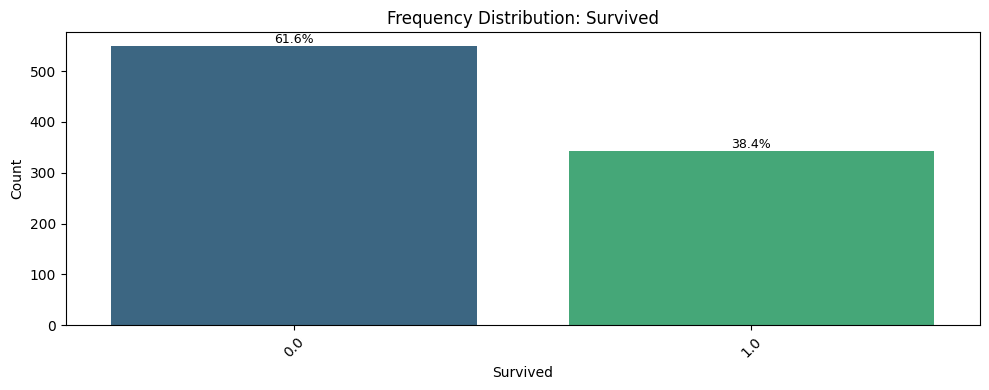

----------------------------------------

--- Categorical Analysis: Pclass ---
Cardinality (unique): 3
Dominant category: 3 (54.2%)
No rare categories


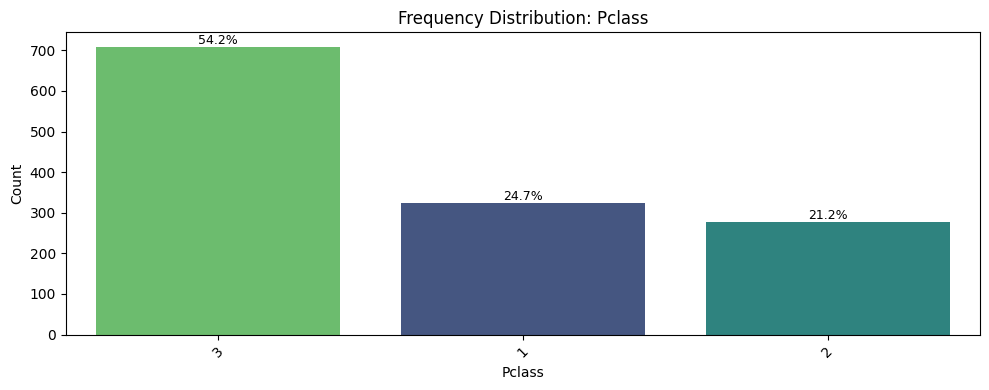

----------------------------------------

--- Categorical Analysis: Sex ---
Cardinality (unique): 2
Dominant category: male (64.4%)
No rare categories


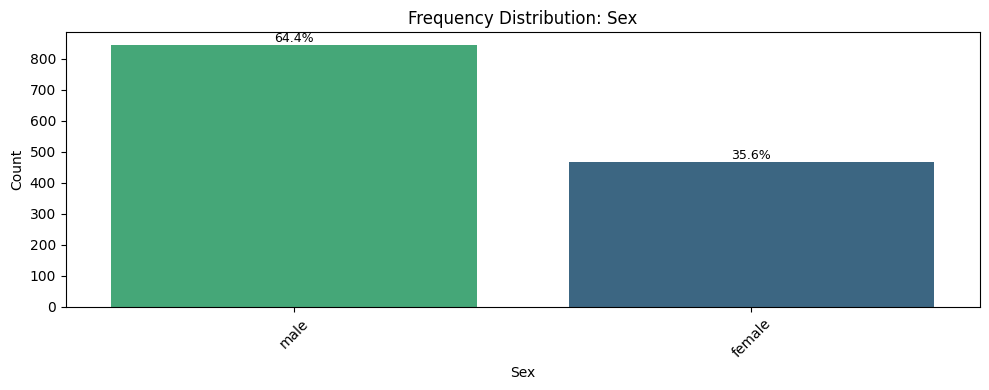

----------------------------------------

--- Categorical Analysis: Embarked ---
Cardinality (unique): 3
Dominant category: S (69.9%)
No rare categories


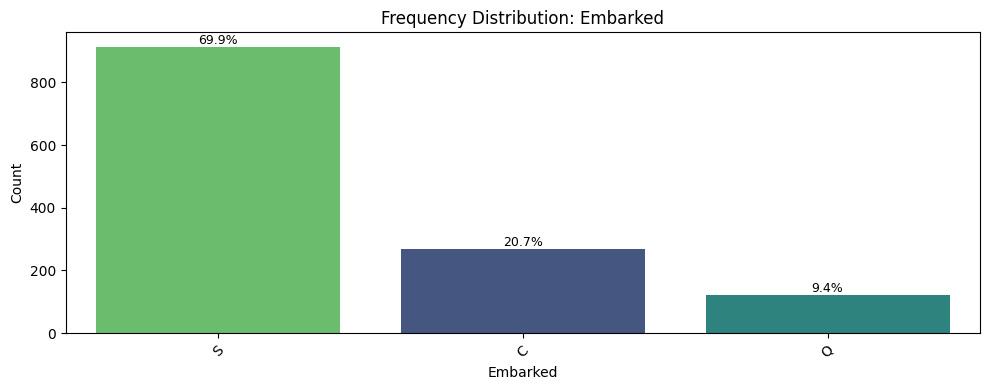

----------------------------------------



In [17]:
for col in cat_cols:
    analyze_categorical(df, col)

In [18]:
for col in cat_cols:
    df[col] = df[col].astype("category")
for col in num_cols:
    df[col] = df[col].astype("float")

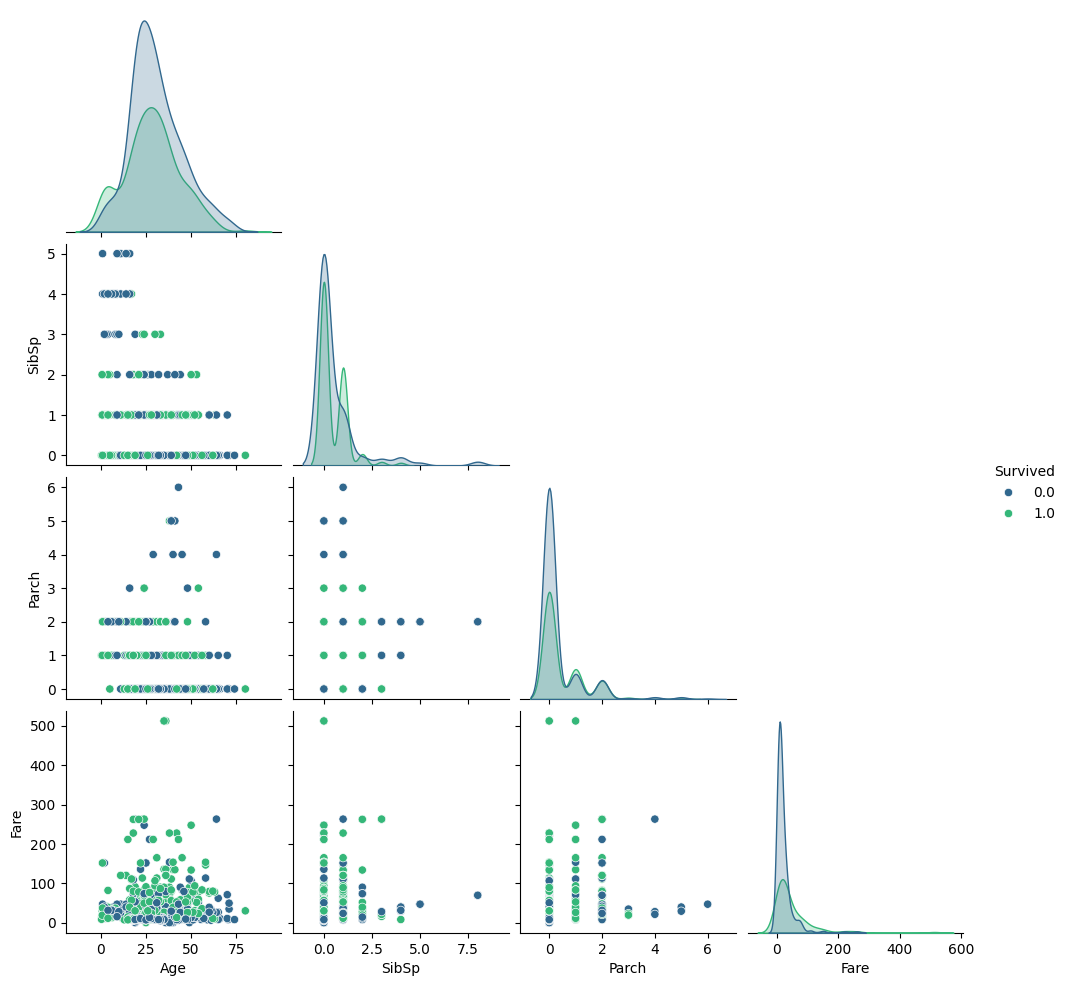

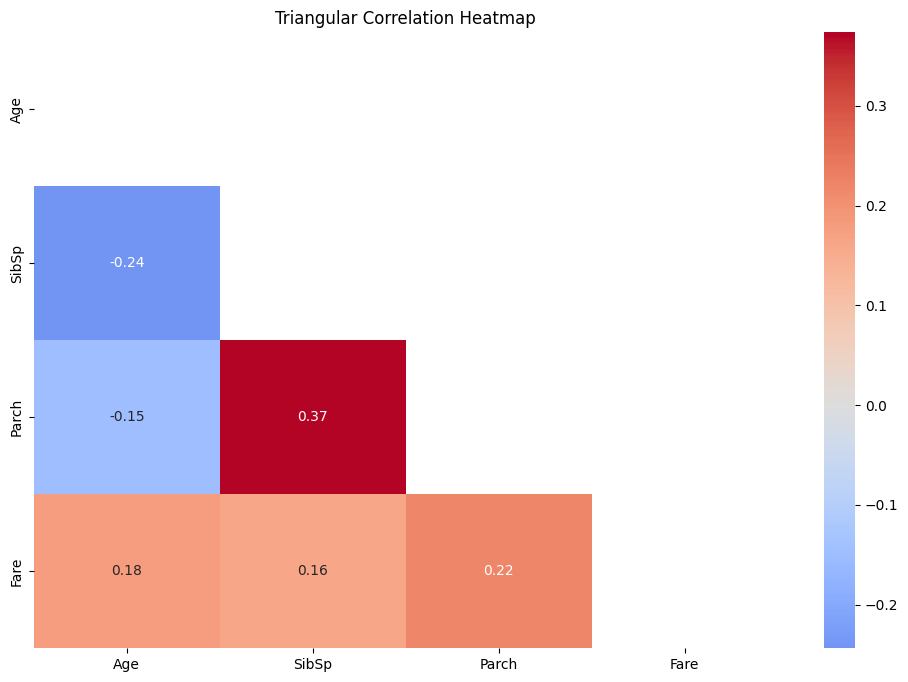

In [19]:
sns.pairplot(df, hue='Survived', diag_kind='kde', corner=True, palette='viridis')
plt.show()

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))
sns.heatmap(df.corr(numeric_only=True), mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Triangular Correlation Heatmap")
plt.show()

In [20]:
age_mean = df["Age"].mean()
df["Age"] = df["Age"].fillna(age_mean)

fare_mean = df['Fare'].mean()
df['Fare'] = df['Fare'].fillna(fare_mean)

embarked_mode = df["Embarked"].mode()
df["Embarked"] = df["Embarked"].fillna(embarked_mode)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    1309 non-null   category
 2   Sex       1309 non-null   category
 3   Age       1309 non-null   float64 
 4   SibSp     1309 non-null   float64 
 5   Parch     1309 non-null   float64 
 6   Fare      1309 non-null   float64 
 7   Embarked  1307 non-null   category
dtypes: category(4), float64(4)
memory usage: 46.6 KB


In [22]:
target_col = "Survived"
cat_cols = [col for col in cat_cols if col != target_col]

In [23]:
cat_cols

['Pclass', 'Sex', 'Embarked']

In [24]:
target = df['Survived'].values

In [25]:
df['Age'] = np.log1p(df['Age'])
df['Fare'] = np.log1p(df['Fare'])

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop'
)
preprocessor.set_output(transform="pandas")

df = preprocessor.fit_transform(df)

In [27]:
df.head()

,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,cat__Embarked_nan,num__Age,num__Fare,num__SibSp,num__Parch
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.277216,-0.898323,0.481288,-0.445
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.597173,1.343689,0.481288,-0.445
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.011716,-0.817085,-0.479087,-0.445
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.464636,1.044367,0.481288,-0.445
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.464636,-0.802717,-0.479087,-0.445


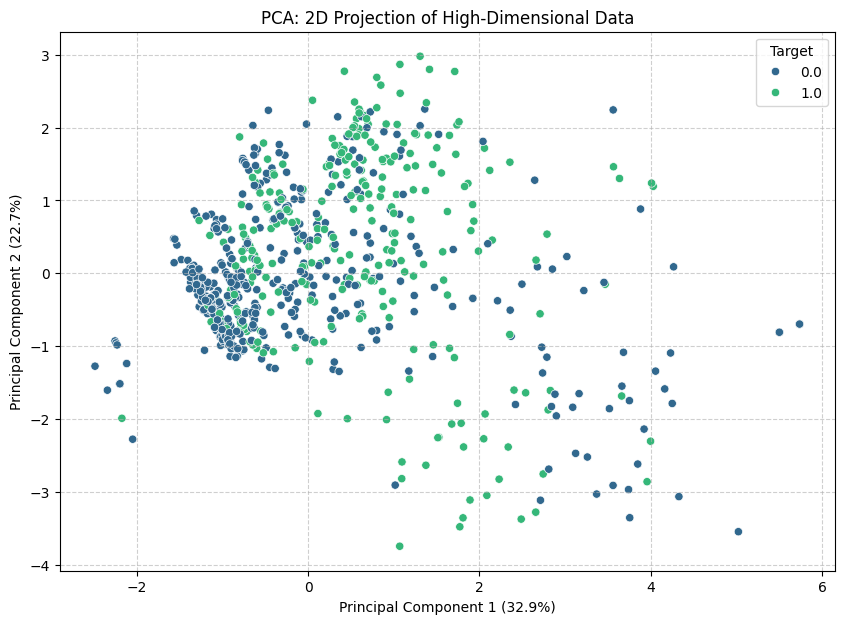

In [28]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Target'] = target

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df, 
    x='PC1', 
    y='PC2', 
    hue='Target', 
    palette='viridis', 
    alpha=1,
    edgecolor='w'
)

exp_var = pca.explained_variance_ratio_ * 100
plt.xlabel(f"Principal Component 1 ({exp_var[0]:.1f}%)")
plt.ylabel(f"Principal Component 2 ({exp_var[1]:.1f}%)")
plt.title("PCA: 2D Projection of High-Dimensional Data")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [29]:
def plot_scree_analysis(df, n_components=10):
    X_numeric = df.select_dtypes(include=[np.number]).dropna()
    X_scaled = StandardScaler().fit_transform(X_numeric)
    
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)
    
    exp_var_ratio = pca.explained_variance_ratio_
    cum_var_ratio = np.cumsum(exp_var_ratio)
    
    plt.figure(figsize=(10, 6))
    
    bars = plt.bar(range(1, len(exp_var_ratio) + 1), exp_var_ratio, 
                   alpha=0.5, align='center', label='Individual Explained Variance', color='skyblue')
    
    plt.step(range(1, len(cum_var_ratio) + 1), cum_var_ratio, 
             where='mid', label='Cumulative Explained Variance', color='red', marker='o')

    plt.axhline(y=0.90, color='green', linestyle='--', label='90% Variance Threshold')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1%}', 
                 ha='center', va='bottom', fontsize=8)

    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Component Index')
    plt.title('Scree Plot: PCA Variance Analysis')
    plt.xticks(range(1, len(exp_var_ratio) + 1))
    plt.legend(loc='center right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    if n_components >= 7:
        print(f"Cumulative Variance explained by 7 components: {cum_var_ratio[6]*100:.2f}%")
        print(f"Cumulative Variance explained by 8 components: {cum_var_ratio[7]*100:.2f}%")

# plot_scree_analysis(df, n_components=min(10, df.shape[1]))

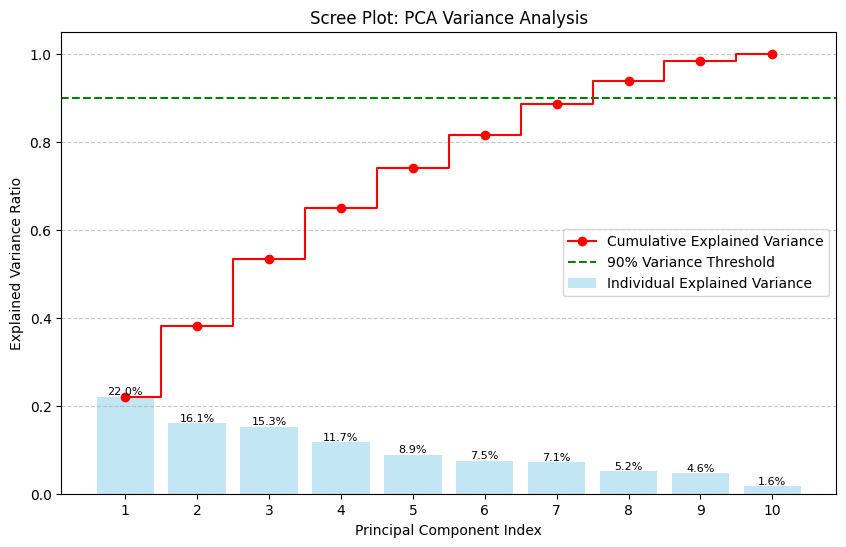

Cumulative Variance explained by 7 components: 88.55%
Cumulative Variance explained by 8 components: 93.70%


In [30]:
plot_scree_analysis(df, n_components=min(10, df.shape[1]))

In [31]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(df)

In [32]:
X_tsne

array([[-10.183249 , -19.994522 ],
       [ 34.40033  ,  15.199628 ],
       [ 29.446661 ,  -9.214459 ],
       ...,
       [-37.977364 ,  -6.618191 ],
       [-32.097485 , -18.059368 ],
       [  7.5435433, -22.717112 ]], dtype=float32)

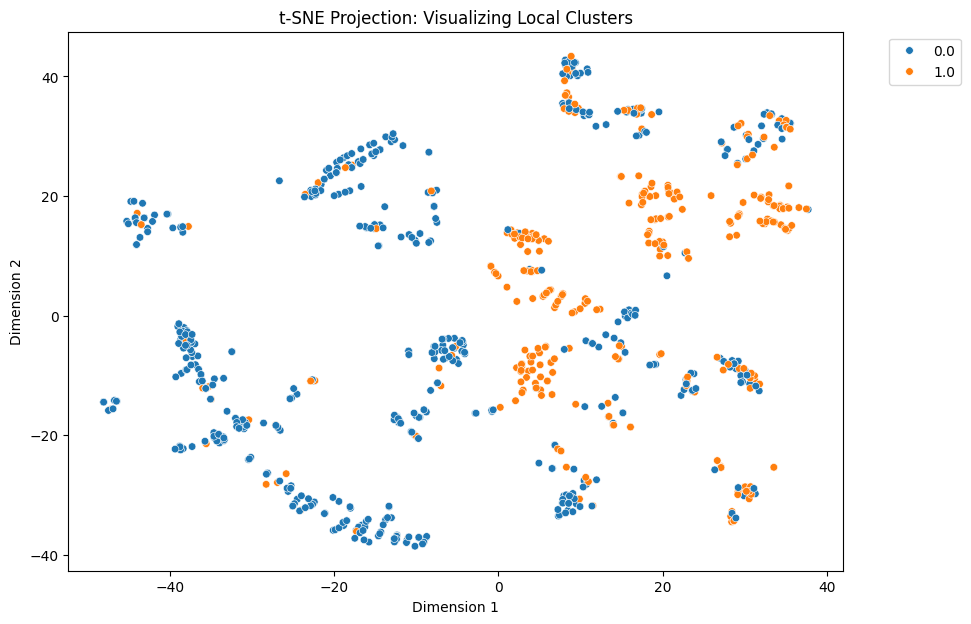

In [33]:
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Target'] = target 

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tsne_df, 
    x='TSNE1', 
    y='TSNE2', 
    hue='Target',
    alpha=1,
    s=30 # Point size
)

plt.title("t-SNE Projection: Visualizing Local Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [34]:
traindata = pd.read_csv("/kaggle/input/titanic/train.csv")
# testdata = pd.read_csv("/kaggle/input/titanic/test.csv")

drop_cols = ['Name', 'PassengerId', 'Cabin', 'Ticket']
df = traindata.drop(columns=drop_cols)

In [35]:
cat_cols = ['Pclass', 'Sex', 'Embarked']
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']

In [36]:
for col in cat_cols:
    df[col] = df[col].astype("category")
for col in num_cols:
    df[col] = df[col].astype("float")
df['Survived'] = df['Survived'].astype("category")

In [37]:
Y = traindata['Survived']
X = df.drop(columns = ['Survived'])

In [38]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1.0,0.0,7.2500,S
1,1,female,38.0,1.0,0.0,71.2833,C
2,3,female,26.0,0.0,0.0,7.9250,S
3,1,female,35.0,1.0,0.0,53.1000,S
4,3,male,35.0,0.0,0.0,8.0500,S


In [39]:
pipe1 = ColumnTransformer([
    ('impute_age', SimpleImputer(strategy='mean'), ['Age']),
    ('impute_fare', SimpleImputer(strategy='mean'), ['Fare']),
    ('impute_embarked', SimpleImputer(strategy='most_frequent'), ['Embarked'])
], remainder='passthrough', verbose_feature_names_out=False)

pipe1.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('impute_age', SimpleImputer(), ['Age']),
                                ('impute_fare', SimpleImputer(), ['Fare']),
                                ('impute_embarked',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['Embarked'])],
                  verbose_feature_names_out=False)

In [40]:
log_transformer = FunctionTransformer(np.log1p, validate=True)
pipe2 = ColumnTransformer([
    ('log_transform', log_transformer, ['Age', 'Fare']),
    ('onehot', OneHotEncoder(sparse_output=False), cat_cols),
    ('scaling', StandardScaler(), num_cols)
], remainder='passthrough', verbose_feature_names_out=False)

pipe2.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('log_transform',
                                 FunctionTransformer(func=<ufunc 'log1p'>,
                                                     validate=True),
                                 ['Age', 'Fare']),
                                ('onehot', OneHotEncoder(sparse_output=False),
                                 ['Pclass', 'Sex', 'Embarked']),
                                ('scaling', StandardScaler(),
                                 ['Age', 'SibSp', 'Parch', 'Fare'])],
                  verbose_feature_names_out=False)

In [97]:
randomforest = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)

xgb = XGBClassifier(
    objective='binary:logistic',
    booster="gbtree",
    n_estimators=3000,
    max_depth=7,
    learning_rate=0.01,
    random_state=42
)

voting = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', randomforest),
        ('xgb', xgb)
    ],
    voting='soft'
)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    max_iter=300
)

hist = HistGradientBoostingClassifier(
    learning_rate=0.01,
    max_iter=1000,
    max_depth=7,
    l2_regularization=0.4
)

kneigh = KNeighborsClassifier(
    n_neighbors=2,
    weights='distance'
)

model = kneigh


In [98]:
pipe = Pipeline([
    ('missingValue', pipe1),
    ('pipe2', pipe2),
    # ('dim_red', PCA(n_components=8)),
    ('classifier', model)
])
pipe

Pipeline(steps=[('missingValue',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_age', SimpleImputer(),
                                                  ['Age']),
                                                 ('impute_fare',
                                                  SimpleImputer(), ['Fare']),
                                                 ('impute_embarked',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])],
                                   verbose_feature_names_out=False)),
                ('pipe2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True),
                                                  ['Age', 'Fare']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Pclass', 'Sex',
                                                   'Embarked']),
                                                 ('scaling', StandardScaler(),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=2, weights='distance'))])

In [99]:
pipe.fit(X, Y)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_function_transformer.py:311: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(warn_msg.format("pandas"))
/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('missingValue',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_age', SimpleImputer(),
                                                  ['Age']),
                                                 ('impute_fare',
                                                  SimpleImputer(), ['Fare']),
                                                 ('impute_embarked',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])],
                                   verbose_feature_names_out=False)),
                ('pipe2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True),
                                                  ['Age', 'Fare']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Pclass', 'Sex',
                                                   'Embarked']),
                                                 ('scaling', StandardScaler(),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=2, weights='distance'))])

In [100]:
pipe.score(X, Y)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_function_transformer.py:311: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(warn_msg.format("pandas"))


0.9820426487093153

In [101]:
testdf = pd.read_csv("/kaggle/input/titanic/test.csv")

In [102]:
drop_cols = ['Name', 'PassengerId', 'Cabin', 'Ticket']
testdf = testdf.drop(columns=drop_cols)

for col in cat_cols:
    testdf[col] = testdf[col].astype("category")
for col in num_cols:
    testdf[col] = testdf[col].astype("float")

In [103]:
pred = pipe.predict(testdf)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_function_transformer.py:311: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(warn_msg.format("pandas"))


In [104]:
testdata = pd.read_csv("/kaggle/input/titanic/test.csv")
submission = pd.DataFrame({
    'PassengerId': testdata['PassengerId'],
    'Survived': pred
})

submission.sort_values(by='PassengerId', ascending=True, inplace=True)

submission.to_csv('my_submission.csv', index=False)
print("Saved successfully to 'my_submission.csv'")

Saved successfully to 'my_submission.csv'
